# Прикладные задачи анализа данных

## Домашнее задание 4

В этой работе мы будем решать задачу рекомендаций музыки. Для этого мы реализуем метод коллаборативной фильтрации и модель со скрытыми переменными, сравним их между собой и попытаемся сделать выводы. Во всех заданиях разрешается переписывать код по своему усмотрению, предложенные шаблоны несут лишь рекомендательный характер.

In [31]:
from sklearn.preprocessing import LabelEncoder

import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
from typing import Callable, List

import matplotlib.pyplot as plt
import seaborn as sns
import scipy.sparse as scs
from scipy import sparse

In [32]:
ratings = pd.read_csv('music_dataset.csv')
ratings.head()

,userId,trackId
0,0,14
1,0,95
2,0,219
3,0,220
4,0,404


In [33]:
tracks_info = pd.read_csv('tracks_info.csv')
tracks_info.head()

,id,name,artists
0,0,What There Is,['a-ha']
1,1,I'll Play The Blues For You,['Albert King']
2,2,Breaking Up Somebody's Home,['Albert King']
3,3,Imma Be,['Black Eyed Peas']
4,4,Boom Boom Pow,['Black Eyed Peas']


Для оценки качества рекомендаций мы будем использовать метрику $MAP@k$.

$$
MAP@k = \frac{1}{N} \sum_{u = 1}^N AP_u@k
$$
$$
AP_u@k = \frac{1}{\min(k, n_u)} \sum_{i=1}^k r_u(i) p_u@i
$$
$$p_u@k = \dfrac{1}{k}\sum_{j=1}^k r_u(j)$$


*   $N$ - количество пользователей.
*   $n_u$ - число релевантных треков пользователя $u$ на тестовом промежутке.
*   $r_u(i)$ - бинарная величина: относится ли трек на позиции $i$ к релевантным.

**Задание 1 (1 балл).** Реализуйте метрику $MAP@k$.

In [34]:
def mapk(relevant: List[List[int]], predicted: List[List[int]], k: int = 20):

    def in_relevant(u, j):
        return predicted[u][j] in relevant[u]

    def p(u, i):
        return sum([in_relevant(u, j) for j in range(i)]) / i

    def ap(u):
        return sum([in_relevant(u, i - 1) * p(u, i) for i in range(1, k + 1)]) / min(k, len(relevant[u]))

    return sum([ap(u) for u in range(len(relevant))]) / len(relevant)

In [35]:
relevant = [
    [1, 7, 6, 2, 8],
    [1, 5, 4, 8],
    [8, 2, 5]
]

pred = [
    [8, 1, 5, 0, 7, 2, 9, 4],
    [0, 1, 8, 5, 3, 4, 7, 9],
    [9, 2, 0, 6, 8, 5, 3, 7]
]

assert round(mapk(relevant, pred, k=5), 4) == 0.4331

Разделим данные на тренировочные и тестовые так, чтобы в теcтовый датасет попали 50 последних треков каждого пользователя.

In [36]:
def train_test_split(ratings):
    train_ratings, test_ratings = [], []
    num_test_samples = 50

    # getting train samples
    for userId, user_data in tqdm(ratings.groupby('userId')):
        train_ratings += [user_data[:-num_test_samples]]

    train_ratings = pd.concat(train_ratings).reset_index(drop=True)
    all_train_items = train_ratings['trackId'].unique()

    # getting train samples
    # we drop all tracks that are not presented it the training samples,
    # because we won't be able to learn representations for them
    for userId, user_data in tqdm(ratings.groupby('userId')):
        test_items = user_data[-num_test_samples:]
        test_items = test_items[np.isin(test_items['trackId'], all_train_items)]
        test_ratings += [test_items]

    test_ratings = pd.concat(test_ratings).reset_index(drop=True)

    return train_ratings, test_ratings

In [37]:
train_ratings, test_ratings = train_test_split(ratings)

  0%|          | 0/241 [00:00<?, ?it/s]

  0%|          | 0/241 [00:00<?, ?it/s]

Почистим табличку с информацией о треках и закодируем id треков так, чтобы они соответствовали их порядковому номеру.

In [38]:
redundant_rows = np.where(~np.isin(tracks_info['id'], train_ratings['trackId'].unique()))[0]
tracks_info.drop(redundant_rows, inplace=True)
tracks_info = tracks_info.reset_index(drop=True)

In [39]:
def ids_encoder(ratings):
    users = sorted(ratings['userId'].unique())
    items = sorted(ratings['trackId'].unique())

    # create users and items encoders
    uencoder = LabelEncoder()
    iencoder = LabelEncoder()

    # fit users and items ids to the corresponding encoder
    uencoder.fit(users)
    iencoder.fit(items)

    return uencoder, iencoder

In [40]:
uencoder, iencoder = ids_encoder(train_ratings)
train_ratings['trackId'] = iencoder.transform(train_ratings['trackId'].tolist())
test_ratings['trackId'] = iencoder.transform(test_ratings['trackId'].tolist())
tracks_info['id'] = iencoder.transform(tracks_info['id'].tolist())

In [41]:
train_ratings.head()

,userId,trackId
0,0,14
1,0,95
2,0,219
3,0,220
4,0,404


In [42]:
test_ratings.head()

,userId,trackId
0,0,57582
1,0,57802
2,0,57957
3,0,58174
4,0,59168


Соберем все релевантные треки для каждого пользователя в список.

In [43]:
test_relevant = []
test_users = []
for user_id, user_data in test_ratings.groupby('userId'):
    test_relevant += [user_data['trackId'].tolist()]
    test_users.append(user_id)

**Задание 2 (1 балл).** Реализуйте метод `get_test_recommendations` в классе `BaseModel`. Он принимает на вход параметр `k` и возвращает массив из `k` наиболее подходящих треков для каждого пользователя. Не забывайте удалять уже прослушанные треки из рекомендуемых.

In [70]:
class BaseModel:
    def __init__(self, ratings: pd.DataFrame):
        self.ratings = ratings
        self.n_users = len(np.unique(self.ratings['userId']))
        self.n_items = len(np.unique(self.ratings['trackId']))

        self.R = np.zeros((self.n_users, self.n_items))
        self.R[self.ratings['userId'], self.ratings['trackId']] = 1.

    def recommend(self, uid: int):
        """
        param uid: int - user's id
        return: [n_items] - vector of recommended items sorted by their scores in descending order
        """
        raise NotImplementedError

    def remove_train_items(self, preds: List[List[int]], k: int):
        """
        param preds: [n_users, n_items] - recommended items for each user
        param k: int
        return: np.array [n_users, k] - recommended items without training examples
        """
        new_preds = np.zeros((len(preds), k), dtype=int)
        for user_id, user_data in self.ratings.groupby('userId'):
            user_preds = preds[user_id]
            new_preds[user_id] = user_preds[~np.in1d(user_preds, user_data['trackId'])][:k]

        return new_preds

    def get_test_recommendations(self, k: int):
        test_preds = []

        for uid in range(self.n_users):
            test_preds.append(self.recommend(uid))

        return self.remove_train_items(test_preds, k)[test_users]

## Часть 1. Коллаборативная фильтрация (User2User)

Идея: чтобы выбрать треки, которые понравятся пользователю, можно набрать несколько похожих на него пользователей (соседей) и посмотреть, какие треки они слушают. После этого остается агрегировать треки этих пользователей и выбрать самые популярные. Соответственно, задача состоит из двух частей: выбора функции похожести двух пользователей и способа агрегации.

В качестве функции похожести мы будем использовать две метрики:

1. Корреляция Пирсона $$s(u, v) = \frac{\sum_{i \in I_u \cap I_v} r_{ui}r_{vi}}{\sqrt{\sum_{i \in I_u} r_{ui} ^2}\sqrt{\sum_{i \in I_v} r_{vi}^2}} $$

2. Мера Жаккара

$$ s(u, v) = \frac{|I_u \cap I_v|}{|I_u \cup I_v|} $$


Корреляция Пирсона немного видоизменена, чтобы подходить под нашу задачу.


Во всех формулах
* $I_u$ - множество треков, прослушанных пользователем $u$.
* $r_{ui}$ - прослушал ли пользователь $u$ трек $i$ (0 или 1).

Множество соседей определим как $$N(u) = \{ v \in U \setminus \{u\} \mid s(u, v) > \alpha\},$$ где $\alpha \, - $ гиперпараметр.



Для агрегации мы будем пользоваться следующей формулой.
$$
\hat{r}_{ui} = \frac{\sum_{v \in N(u)} s(u, v) r_{vi}}{\sum_{v \in N(u)} |s(u, v)|}
$$

**Задание 3.1 (1 балл).** Реализуйте функцию подсчета корреляции Пирсона.

**Задание 3.2 (1 балл).** Реализуйте функцию подсчета меры Жаккара.

Функции принимают матрицу оценок и вектор оценок пользователя $u$ и возвращают вектор со значениями похожести пользователя $u$ на всех пользователей. Старайтесь писать оптимизированный код, за неэффективную реализацию оценка может быть снижена.

In [45]:
def pearson(ratings: np.array, user_vector: np.array) -> np.array:
    # your code here: (￣▽￣)/♫•*¨*•.¸¸♪

    inter_user_products = ratings @ user_vector

    user_norm = np.linalg.norm(user_vector)
    users_norms = np.linalg.norm(ratings, axis=1)

    return inter_user_products / (user_norm * users_norms)


def jaccard(ratings: np.array, user_vector: np.array) -> np.array:
    # your code here: (￣▽￣)/♫•*¨*•.¸¸♪

    intersection = np.sum(np.logical_and(user_vector, ratings), axis=1)
    union = np.sum(np.logical_or(user_vector, ratings), axis=1)
    return intersection / union

**Задание 4 (1 балл).** Реализуйте методы `similarity` и `recommend` класса `User2User`. `recommend` возвращает индексы треков, отсортированные в порядке убывания предсказанных оценок.


In [96]:
class User2User(BaseModel):
    def __init__(self, ratings, similarity_func):
        super().__init__(ratings)

        assert similarity_func in [pearson, jaccard]

        self.similarity_func = similarity_func
        self.alpha = 0.02

    def similarity(self, user_vector: np.array):
        """
        user_vector: [n_items]
        """
        # your code here: (￣▽￣)/♫•*¨*•.¸¸♪
        return self.similarity_func(self.R, user_vector)

    def recommend(self, uid: int):
        # your code here: (￣▽￣)/♫•*¨*•.¸¸♪
        sim = self.similarity(self.R[uid])
        others_sim = np.delete(sim, uid)
        others_ratings = np.delete(self.R, uid, axis=0)
        neighbors = others_sim > self.alpha
        scores = np.sum((neighbors * others_sim).reshape(neighbors.shape[0], 1) * others_ratings, axis=0) / np.sum(neighbors * others_sim)
        return np.argsort(-scores)


**Задание 5 (1 балл).** Постройте графики зависимости значений $MAP@k$ от разных $k$ для обоих функций похожести, сравните их между собой, а также с предсказаниями случайного алгоритма и сделайте выводы.

In [97]:
ks = range(1, 20, 2)

MAPk_jaccard = []
MAPk_pearson = []
MAPk_random = []

for k in ks:

    u2u_j = User2User(train_ratings, jaccard)
    pred_relevant = u2u_j.get_test_recommendations(k)
    MAPk_jaccard.append(mapk(test_relevant, pred_relevant, k))


    u2u_p = User2User(train_ratings, pearson)
    pred_relevant = u2u_p.get_test_recommendations(k)
    MAPk_pearson.append(mapk(test_relevant, pred_relevant, k))


    n_items = len(np.unique(train_ratings['trackId']))
    random_pred = np.asarray([np.random.permutation(n_items) for _ in range(len(test_users))])
    MAPk_random.append(mapk(test_relevant, random_pred, k))

<ipython-input-96-6506d0e4886a>:23: RuntimeWarning: divide by zero encountered in divide
  scores = np.sum((neighbors * others_sim).reshape(neighbors.shape[0], 1) * others_ratings, axis=0) / np.sum(neighbors * others_sim)
<ipython-input-96-6506d0e4886a>:23: RuntimeWarning: invalid value encountered in divide
  scores = np.sum((neighbors * others_sim).reshape(neighbors.shape[0], 1) * others_ratings, axis=0) / np.sum(neighbors * others_sim)


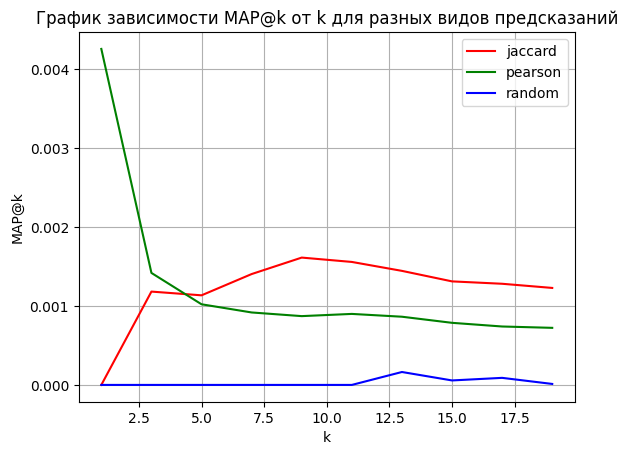

In [98]:
plt.plot(ks, MAPk_jaccard, color='red', label='jaccard')
plt.plot(ks, MAPk_pearson, color='green', label='pearson')
plt.plot(ks, MAPk_random, color='blue', label='random')

plt.title('График зависимости MAP@k от k для разных видов предсказаний')
plt.xlabel('k')
plt.ylabel('MAP@k')
plt.grid()
plt.legend()
plt.show()

**Комментарий: ** лучше всего справляется модель с использовании корреляции Пирсона в качестве функции схожести, а так же наилучшие результаты соответствуют наименьшему значению k:

In [99]:
ind = np.argmax(MAPk_pearson)
ks[ind]

1

что, конечно, не очень хорошо. Угадать один трек для пользователя верно легко, но в реальной жизни мы вряд ли будет ограничиваться предсказанием только одного объекта.

**Задание 6 (1.5 балла).** Как вы могли заметить, матрица оценок получается очень разреженной, но мы работаем с ней как с обычной, это не дело. Перепишите код так, чтобы все методы могли работать с разреженными матрицами и сравните скорость работы такого подхода с оригинальным.

Мы можем посмотреть глазами, насколько хорошо модель рекомендует треки. Для этого сравним уже прослушанные треки с рекомендованными и релевантными для случайного пользователя. Хорошо ли у вас получилось?

In [36]:
model = User2User(train_ratings, pearson)
user_id = np.random.randint(0, model.n_users)

In [37]:
listened_tracks = train_ratings[train_ratings.userId == user_id].trackId[:15]

print('Already listened tracks:')

tracks_info.loc[listened_tracks][['name', 'artists']]

Already listened tracks:


,name,artists
179,I Walk Alone,['Tarja']
220,I Was Made For Lovin' You,['Kiss']
234,Wind Of Change,['Scorpions']
257,The Lady In Red,['Chris De Burgh']
385,Your Latest Trick,['Dire Straits']
396,The Phantom Of The Opera,"['Nightwish', 'Andrew Lloyd Webber']"
411,Don't Cry,"[""Guns N' Roses""]"
419,The Real Slim Shady,['Eminem']
474,Tom's Diner,"['DNA', 'Suzanne Vega', 'Nick Batt', 'Neal Sla..."
685,Ode To My Family,['The Cranberries']


In [38]:
preds = model.get_test_recommendations(15)

print('Predicted tracks:')

tracks_info.loc[preds[user_id]][['name', 'artists']]

<ipython-input-32-6506d0e4886a>:23: RuntimeWarning: divide by zero encountered in divide
  scores = np.sum((neighbors * others_sim).reshape(neighbors.shape[0], 1) * others_ratings, axis=0) / np.sum(neighbors * others_sim)
<ipython-input-32-6506d0e4886a>:23: RuntimeWarning: invalid value encountered in divide
  scores = np.sum((neighbors * others_sim).reshape(neighbors.shape[0], 1) * others_ratings, axis=0) / np.sum(neighbors * others_sim)


Predicted tracks:


,name,artists
1073,Smells Like Teen Spirit,['Nirvana']
1019,It's My Life,['Bon Jovi']
11493,"Baby, Its Cold Outside",['Rosemary Clooney']
2555,Californication,['Red Hot Chili Peppers']
4032,Bring Me To Life,['Evanescence']
1056,Don't Speak,['No Doubt']
2799,In the End,['Linkin Park']
9694,We Will Rock You,['Queen']
5872,Я свободен,['Кипелов']
2767,What I've Done,['Linkin Park']


In [39]:
test_tracks = test_ratings[test_ratings.userId == user_id].trackId[:15]

print('Test-time tracks:')

tracks_info.loc[test_tracks][['name', 'artists']]

Test-time tracks:


,name,artists
21591,Anodyne Sea,['As I Lay Dying']
21901,Time to Say Goodbye,"['Jeff Williams', 'Casey Lee Williams']"
24141,Straight Gutta,"['Method Man', 'Streetlife', 'Redman', 'Hanz On']"
24158,Kings Never Die,"['Eminem', 'Gwen Stefani']"
27586,Просто друг,['Чай вдвоём']
29139,What'd I Say PART 1 & 2,['Ray Charles']
29992,Crash,['Fit For Rivals']
31623,Отпускаю,['Храмыч']
32078,Just You and I,['Tom Walker']
33436,Caribbean Rave,['W&W']


**Пока качество рекомендаций** не самое лучшее: прсказанные треки совсем не совпадают хотя бы по исполнилтелям с тестовой выборкой. Не уверена, попадают ли наши рекомендации в любимые жанры пользователя: кажется, что местами да (предсказани песню The Cardigans, зная, что пользователь слушал the Cranberies - это из одной опервы, так что в целом неплохо), а местами совсе мимо (например, предсказание Кипелова как-то не вписывается в общий музыкальный ряд пользователя)

будем улучшать!

### Часть 2. Модель со скрытыми переменными

В этой части мы пощупаем метод рекомендаций со скрытыми переменными.
Идея: будем предсказывать оценки по формуле
$$
\hat{r}_{ui} = \langle p_u, q_u \rangle,
$$
$p_u \in \mathbb{R}^d$ и $q_i \in \mathbb{R}^d$ - латентные векторы пользователя $u$ и объекта $i$ соответственно.

Оптимизировать мы будем MSE между истинной оценкой пользователя и предсказанной с регуляризацией
$$
L = \sum_{(u, i) \in R} (\hat{r}_{ui} - r_{ui})^2 + \lambda \left(\sum_{u \in U} \|p_u\|^2 + \sum_{i \in I} \|q_i\|^2\right)
$$

**Задание 7 (1.5 балла).** На лекции рассматривались два подхода к оптимизации параметров. Можно это делать обычным стохастческим градинтным спуском, а можно по очереди обновлять матрицы $P, Q$, и тогда получится метод Alternating Least Squares (ALS). Выведите формулы обновления параметров для обоих методов.

**LFM:**

Матрицу пользователей и матрица айтемов заполняем слуайными значениями. На каждом шаге выбираем случайную пару $(u, i)$. Возьмем градиент от функции потерь (приведенной выше) по параметрам, а также учтем, что $\hat{r}_{ui} = \langle p_u, q_i \rangle$:

$$
\frac{\partial L}{\partial p_u} = 2(\langle p_u, q_i \rangle - r_{ui}) \cdot q_i + 2\lambda \cdot p_u\\
\frac{\partial L}{\partial q_i} = 2(\langle p_u, q_i \rangle - r_{ui}) \cdot p_u + 2\lambda \cdot q_i
$$

Пусть $p'_u, q'_i$ - обновленные коэффициенты, $\eta$ - длина шага,тогда: которой заменим $p_u, q_i$, а за . Константу 2 в градиентах можно опустить. Учитываем $r_{ui} = 1$. Тогда:

$$
p'_u = p_u - \eta((\langle p_u, q_i \rangle - 1) \cdot q_i - \lambda \cdot p_u) = p_u - \eta(\langle p_u, q_i \rangle - 1) \cdot q_i - \eta\lambda \cdot p_u\\ \\
q'_i = q_i - \eta((\langle p_u, q_i \rangle - 1) \cdot p_u - \lambda \cdot q_i) = q_i - \eta(\langle p_u, q_i \rangle - 1) \cdot p_u - \eta\lambda \cdot q_i
$$

\\
**ALS:**

На один шаг положим одну из матриц $P, Q$ константной. Сначала зафиксируем матрицу $Q$. Тогда:

$$
\frac{\partial L}{\partial p_u} =  
p_u = \left( \sum_i(q_iq_i^T) + \lambda I \right)^{-1} \sum_i r_{ui}q_i = \left( Q_u^TQ_u + \lambda I \right)^{-1} \sum_{i : r_{ui} = 0} q_i
$$

Аналогично получаем и выражение для $q_i$ при фиксированной матрице $P$:

$$
q_i = \left( \sum_u(p_up_u^T) + \lambda I \right)^{-1} \sum_u r_{ui}p_u = \left( P_i^TP_i + \lambda I \right)^{-1} \sum_{u : r_{ui} = 0} p_u
$$


**Задание 8 (2 балла).** Реализуйте методы оптимизации параметров для обоих алгоритмов.

In [72]:
class HiddenVars(BaseModel):
    def __init__(self, ratings, dim=128, mode='sgd'):
        super().__init__(ratings)
        self.dim = dim

        assert mode in ['sgd', 'als']
        self.mode = mode

        self.P = np.random.normal(size=(self.n_users, dim))
        self.Q = np.random.normal(size=(self.n_items, dim))

        self.known = np.transpose(self.R.nonzero())

        self.lr = 0.0003
        self.lamb = 0.01

        self.R = scs.csr_array(self.R)

    def fit(self, num_iters=5):

        for epoch in tqdm(range(num_iters)):

            if self.mode == 'sgd':
                # your code here: (￣▽￣)/♫•*¨*•.¸¸♪
                t = np.random.randint(0, len(self.known))
                u, i = self.known[t]

                new_p = self.P[u] - self.lr * (self.P[u] @ self.Q[i] - 1) * self.Q[i] - self.lr * self.lamb * self.P[u]
                new_q = self.Q[i] - self.lr * (self.P[u] @ self.Q[i] - 1) * self.P[u] - self.lr * self.lamb * self.Q[i]

                self.P[u] = new_p
                self.Q[i] = new_q

            elif self.mode == 'als':
                RQ = self.R @ self.Q
                for u in range(self.n_users):
                    relevant_items = self.ratings[self.ratings['userId'] == u].trackId
                    Q_rel = self.Q[relevant_items]
                    QQ = Q_rel.reshape(-1, self.dim, 1) * Q_rel.reshape(-1, 1, self.dim)
                    self.P[u] = np.linalg.inv(QQ.sum(axis=0) + self.lamb * np.eye(self.dim)) @ RQ[u]

                RP = self.R.T @ self.P
                for i in range(self.n_items):
                    relevant_users = self.ratings[self.ratings['trackId'] == i].userId
                    P_rel = self.P[relevant_users]
                    PP = P_rel.reshape(-1, self.dim, 1) * P_rel.reshape(-1, 1, self.dim)
                    self.Q[i] = np.linalg.inv(PP.sum(axis=0) + self.lamb * np.eye(self.dim)) @ RP[i]

    def recommend(self, uid):
        pred_rating = self.P[uid] @ self.Q.T

        return np.argsort(pred_rating)[::-1]

**Задание 9 (1 балл).** Для обоих алгоритмов подберите оптимальные значения размерности скрытого пространства $d$ и размера предсказания $k$. Как изменяется качество предсказаний с числом итераций обучения? Постройте соответствующие графики, сравните со случайным подхом и User2User, сделайте выводы. Какой алгоритм вам кажется более подходящим для данной задачи и почему?

P.S. Хотя бы один из методов обучения должен приводить к лучшим результатам в сравнении с User2User подходом.

P.P.S. Методу LFM свойственно переобучаться, поэтому при подборе параметров полезно смотреть на значения ошибки и оптимизируемой метрики на тренировочном датасете. Вы также можете менять начальную инициализацию и прочие параметры, за исключением архитектуры, на ваш вкус.

### SGD

In [82]:
dims = range(32, 256, 32)
ks = range(1, 20, 2)


results_sgd = {'dim': [], 'k': [], 'MAPk': []}

for dim in tqdm(dims):
    m = HiddenVars(train_ratings, dim, mode='sgd')
    m.fit(1000)
    for k in ks:

        results_sgd['dim'].append(dim)
        results_sgd['k'].append(k)

        preds = m.get_test_recommendations(k)
        results_sgd['MAPk'].append(mapk(test_relevant, preds, k))

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [84]:
ind = np.argmax(results_sgd['MAPk'])
print('best MAP@k: ', results_sgd['MAPk'][ind])
print('dim: ', results_sgd['dim'][ind])
print('k: ', results_sgd['k'][ind])

best MAP@k:  0.00425531914893617
dim:  32
k:  1


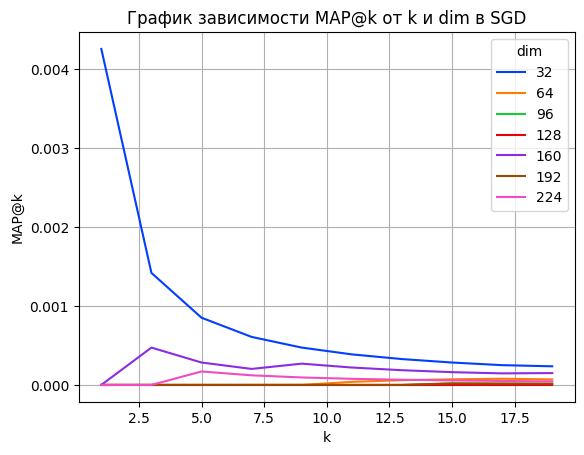

In [86]:
sns.lineplot(pd.DataFrame(results_sgd), x='k', y='MAPk', hue='dim', palette='bright')
plt.title('График зависимости MAP@k от k и dim в SGD')
plt.xlabel('k')
plt.ylabel('MAP@k')
plt.grid()
plt.show()

**Комментарий**: наилучшие результаты мы видим при использовании маленькой размерности (в нашем случае - 32) и на маленьких значения k (1).

### ALS

In [92]:
# из-за долгой работы (видимо, из-за обращении матрицы) здесь я немного сократила выбор измерений
dims = range(12, 72, 12)
ks = range(1, 20, 4)

results_als = {'dim': [], 'k': [], 'MAPk': []}

for dim in tqdm(dims):
    hv = HiddenVars(train_ratings, dim, mode='als')
    hv.fit()
    for k in ks:
        results_als['dim'].append(dim)
        results_als['k'].append(k)
        results_als['MAPk'].append(mapk(test_relevant, hv.get_test_recommendations(k), k))

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

In [93]:
ind = np.argmax(results_als['MAPk'])
print('best MAP@k: ', results_als['MAPk'][ind])
print('dim: ', results_als['dim'][ind])
print('k: ', results_als['k'][ind])

best MAP@k:  0.00851063829787234
dim:  48
k:  1


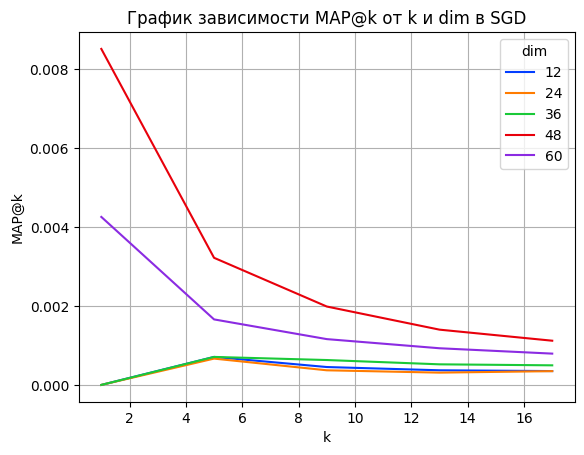

In [94]:
sns.lineplot(pd.DataFrame(results_als), x='k', y='MAPk', hue='dim', palette='bright')
plt.title('График зависимости MAP@k от k и dim в SGD')
plt.xlabel('k')
plt.ylabel('MAP@k')
plt.grid()
plt.show()

**Комментарий:** модель ALS справилась лучше всего: ее наилушчее качество в два раза лучше, чем наилучшее качется модели со скрытыми переменными, обученной на sgd, и user2user.

Если у вас получилось достаточно хорошее качество, то при оптимизации параметров марицы $Q$ похожим трекам стали соответствовать похожие векторы. Поэтому мы можем для любого трека найти наиболее близкие к нему в латентном пространстве и проверить степерь обученности модели вручную.

In [52]:
model = HiddenVars(train_ratings, dim=12, mode='als')
model.fit()

example_trackId = tracks_info[tracks_info.name == 'Выхода нет'].iloc[0].id

preds = model.Q @ model.Q[example_trackId]
preds = preds / np.sqrt((model.Q**2).sum(axis=1) + 1e-8)

track_idxs = preds.argsort()[::-1][:20]

  0%|          | 0/5 [00:00<?, ?it/s]

In [53]:
similar_tracks = tracks_info.loc[track_idxs][['name', 'artists']]
similar_tracks['similarity'] = preds[track_idxs] / np.linalg.norm(model.Q[example_trackId])
similar_tracks

,name,artists,similarity
5512,Выхода нет,['Сплин'],1.000000
16192,Снег,['Машина времени'],0.991150
26580,Short Peace,['Ewan Dobson'],0.977474
757,Take A Look Around,['Limp Bizkit'],0.973476
58764,"skyscrapers (love now, cry later)",['Lil Peep'],0.972532
5213,Eyes On Fire,['Blue Foundation'],0.971206
4742,Awake and Alive,['Skillet'],0.971142
48952,Песня на бис,['Anton Stankevic Jr'],0.970154
26807,Princess,['Wildways'],0.969544
1204,This Love,['Maroon 5'],0.969159
